In [1]:
from __future__ import division

import re
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import qgrid

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score
from sklearn.metrics.pairwise import cosine_similarity
from IPython.display import display

%matplotlib inline
from pylab import rcParams

# Configurations
rcParams['figure.figsize'] = 15, 10
plt.style.use('fivethirtyeight')
reload(sys)
sys.setdefaultencoding("utf-8")
qgrid.nbinstall(overwrite=True)

# This [post](https://eddiewharton.com/2016/05/27/south-park "Post") explains the following exploration of South Park in more detail.

In [2]:
# Data source: https://github.com/BobAdamsEE/SouthParkData
# Includes all south park dialogue from the first episode to the 9th episode of the 18th season
sp = pd.read_csv('data/all-seasons.csv',encoding='latin1')

# Scraped from http://www.imdb.com/list/ls008123404/
imdb = pd.read_csv('data/imdb_clean.csv')


In [3]:
# Some string cleaning
sp.character = sp.character.str.replace('Mr ', 'Mr. ')
sp.character = sp.character.str.replace('Mrs ', 'Mrs. ')
sp.character = sp.character.str.replace(':|,|;','')

In [4]:
sp.head(4)

,season,episode,character,line
0,10,1,Stan,"You guys, you guys! Chef is going away. \n"
1,10,1,Kyle,Going away? For how long?\n
2,10,1,Sta,Forever.\n
3,10,1,Chef,I'm sorry boys.\n


In [5]:
imdb.head()

,episode_title,rating,number_of_votes,season,episode,is_multi_part_episode
0,Cartman Gets an Anal Probe,8.3,2026,1,1,False
1,Weight Gain 4000,8.0,1580,1,2,False
2,Volcano,8.0,1480,1,3,False
3,Big Gay Al's Big Gay Boat Ride,7.8,1443,1,4,False
4,An Elephant Makes Love to a Pig,7.8,1347,1,5,False


In [6]:
# Sort by season and episode and then add episode numbers
imdb.sort_values(['season','episode'],inplace=True)
imdb['episode_number']=range(1,len(imdb)+1)


In [7]:
# Remove rows that are a repetition of the column headers
sp = sp[sp.season!='Season']

# Convert season and episode to int dtype
sp.season = sp.season.astype(int)
sp.episode = sp.episode.astype(int)

sp.sort_values(['season','episode'],inplace=True)

In [11]:
# Determine the episode number for each episode 
episode_key = sp.groupby(['season','episode'],as_index=False)['line'].count()
episode_key['episode_number']=range(1,len(episode_key.line)+1)
sp = sp.merge(episode_key[['season','episode','episode_number']],on=['season','episode'],how='left')

In [12]:
# Join the IMDB ratings data with the transcript data.
# Note that this drops season 19 and the last episode of season 18 from IMDB as 
# neither are in the transcript data.
sp = sp.merge(imdb[['episode_number','episode_title','rating','number_of_votes']],on='episode_number',how='left')

# Words Predictive a Character is Talking: Classifying for Fun

In [16]:
# min_df is set to 75 in order to drop words that were frequently said, but only in one or 
# two episodes i.e. to reduce some overfitting. 
vec = TfidfVectorizer(ngram_range=[1,3],min_df=75,stop_words='english',encoding='latin1')
X_words = vec.fit_transform(sp.line)

In [17]:
# This list includes main characters and minor ones that had funny / distinctive words.
characters_to_predict = ['Randy','Cartman','Chef','Butters','Kanye','Coon','Kyle',
                         'Mr. Garrison','Stan','Satan','Jimbo','Kenny','Jesus','Towelie']

def generate_character_words(sp,characters_to_predict,X_words,include_coef=False):
    '''
    Generates a list of words predictive that a charater is speaking. 
    '''
    character_words= pd.DataFrame()
    for character in characters_to_predict:
        y = sp.character==character
        # This is optimized to be funny, not to generalize well (hence no cross validation). Simply, other  
        # regularizations weren't as funny and L1 was too sparse for minor characters.
        model = LogisticRegression(penalty='l2')
        model_words = model.fit(X_words,y)
        
        # Build a vocabularly of features and sort by coefficients size.
        vocab = pd.DataFrame( zip(model_words.coef_[0],vec.get_feature_names()))
        vocab.columns=['coef_%s' %character,character]
        vocab = vocab.sort_values('coef_%s' %character,ascending=False).reset_index(drop=True)
        
        # Add the regression coefficients for each character if include_coef is True.
        output_cols = [character]
        if include_coef:
            output_cols.append('coef_%s' %character)
        character_words = pd.concat([character_words,vocab[output_cols]],axis=1)
    return character_words

These are the predictive words with their coefficients:

In [18]:
# Examine characters' predictive words and their coefficients to check for signs of multicollinearity. 
# Here, that looks like words I expect to co-occur having opposite signs for the coefficients. This has been 
# tuned to minimize that.

# Also notice that unpredictive words are similar across charatcers. 
# For example, Stan says 'Dude' a lot and others don't. The unpredictive words that are also character names 
# shows which characters rarely interact.
generate_character_words(sp,characters_to_predict,X_words=X_words,include_coef=True).head()

,Randy,coef_Randy,Cartman,coef_Cartman,Chef,coef_Chef,Butters,coef_Butters,Kanye,coef_Kanye,...,Satan,coef_Satan,Jimbo,coef_Jimbo,Kenny,coef_Kenny,Jesus,coef_Jesus,Towelie,coef_Towelie
0,sharon,6.918450,eric cartman,3.628823,children,6.658899,fellas,4.966278,fish,4.694664,...,chris,6.625084,ned,8.484367,woohoo,3.701771,santa,3.372366,towel,5.808187
1,stanley,3.333456,jew,3.154625,women,2.582803,wuh,3.178408,yo,2.747993,...,party,2.726298,mayor,2.554416,fuck,2.910162,father,3.036128,high,5.598276
2,stan,3.286440,jews,3.095820,doctor,2.547535,eric,2.840176,gay,2.706878,...,heaven,2.380457,shoot,2.525339,fucking,2.788038,son,2.509328,goin,2.951870
3,shelly,3.240784,guys,3.071081,goin,2.445971,nothin,2.643369,hold,1.793065,...,god,2.079355,war,2.407574,fuckin,2.706768,air,2.144960,bring,2.787049
4,gerald,2.954556,ey,2.915283,pip,2.399574,uh,2.616706,yes,1.677085,...,just,1.710421,cows,2.193652,stick,2.474720,tonight,2.097227,forget,1.975591


Here are the words without the coefficients:

In [14]:
generate_character_words(sp,characters_to_predict,X_words=X_words,include_coef=False)

,Randy,Cartman,Chef,Butters,Kanye,Coon,Kyle,Mr. Garrison,Stan,Satan,Jimbo,Kenny,Jesus,Towelie
0,sharon,eric cartman,children,fellas,fish,coon,fatass,mr hat,dude,chris,ned,woohoo,santa,towel
1,stanley,jew,women,wuh,yo,friends,ike,children,dad,party,mayor,fuck,father,high
2,stan,jews,doctor,eric,gay,fucking,cartman,mr,don care,heaven,shoot,fucking,son,goin
3,shelly,guys,goin,nothin,hold,mom,brother,teacher,cartman,god,war,fuckin,air,bring
4,gerald,ey,pip,uh,yes,guys,mr hankey,eric,chef,just,cows,stick,tonight,forget
5,son,kyle,black,ah,love,fuck,hankey,hat,killed,bye,history,uh huh,best,asshole
6,internet,son bitch,doin,lady,sorry,evil,bastards,class,come guys,need,holy,hey guys,super,oh man
7,muhammad,scott,bad,dad,alright,captain,dude,stanley,dude don,hi,randy,awesome,evil,wait
8,drive,mom,damn,grandma,fun,guy,stan,principal,wendy,night,gun,ow,muhammad,don
9,music,token,sexual,mom dad,em,dark,fat,sexual,return,know,men,don know,eyes,maybe


If you are a fan of South Park, those probably aren’t very surprising. However, they are quite funny such as Cartman saying “seriously” or “ey”.  You can see a lot of characters’ signature phrases such as Kenny saying “woohoo” or Towelie saying “high”. You can also see specific jokes from memorable episodes such as Kanye saying “fish”. It’s also funny to see how many of Butters’ words are non-committal sounds such as “uh”, “wuh” and “ih”.



In [16]:
# Output characters' predictive words without coefficients to excel for formatting
character_words = generate_character_words(sp,characters_to_predict,X_words,include_coef=False)
character_words.head(20).to_excel('output_tables/south park character words.xlsx')

# Character Statistics: Kanye Is Almost as Narcissistic as Satan. The Announcer is less Narcissistic than Jesus. 


(This uses the percentage of words that are self referential as a measure of narcissism)

In [17]:
def make_text_features(df,col,inplace=False):
    '''
    Generates features on a text column.
    '''
    if inplace:
        frame=df
    else:
        frame=df.copy()
    frame[col] = frame[col].fillna(' ')
    frame['number_of_words'] = frame[col].map(lambda x: len(x.split()))
    frame['number_of_characters'] = frame[col].map(lambda x: len(x))
    
    # The first str.replace removes punctuation and numbers. The second str.replace change new line characters to spaces.
    frame['clean_text'] = frame[col].str.replace('[\!|\?|\.|\,|\'|\"]',"").str.replace('\n+\r*',' ').fillna(' ')
    
    # Finds the length of the longest word in the line
    frame['length_longest_word'] = frame.clean_text.map(lambda x: len(max(x.split(),key=len)))    
    
    # Counts number of self referential words as this can be used as an informal measure of narcissism
    frame['count_self_ref'] = frame[col].str.findall('(i |me|my|mine|i\'m|i\'ll)', re.IGNORECASE).map(len)
    return frame

sp = make_text_features(sp,'line')

In [18]:
def central_characters(sp,n=20):
    '''
    Returns a list of the top n characters who have the most lines.
    '''
    characters = sp.groupby('character',as_index=False).count().sort_values('line',ascending=False).head(n)
    characters = characters.character.tolist()
    return characters


In [19]:
# Dataframe of the count of each times each characters had an epsiode's final line
last_lines = sp.groupby(['episode_number','season'],as_index=False)[['character','line']].last()

# Determine if a line is an n_word monogogue
n_word_monologue = 30
sp['is_monologue'] = sp.number_of_words> n_word_monologue

# Calculate a number of self explanatory statistics for each character
char_stats = sp.groupby('character').sum()[['number_of_words','count_self_ref']]
char_stats['percent_of_words_that_refer_to_self'] = (char_stats.count_self_ref / char_stats.number_of_words).round(4)*100
char_stats['percent_of_lines'] = (sp.groupby('character').count()[['line']] / len(sp)).round(4)* 100
char_stats['percent_of_words'] = (sp.groupby('character').sum()[['number_of_words']] / sp.number_of_words.sum()).round(4)*100
char_stats['final_episode_lines'] = last_lines.groupby(['character'])[['line']].count()
char_stats['mean_words_per_line'] = sp.groupby('character')[['number_of_words']].mean()
char_stats['count_of_%s_word_monologues' %n_word_monologue] = sp.groupby('character')[['is_monologue']].sum()


In [20]:
# Top 20 character by lines
central_characters_lst = central_characters(sp,20)

# Add in the additional characters from the predictive words for fun
central_characters_lst.extend(characters_to_predict)

char_stats[char_stats.index.isin(central_characters_lst)].fillna(0)[[
        'percent_of_lines','mean_words_per_line','count_of_30_word_monologues'
        ,'final_episode_lines','percent_of_words_that_refer_to_self']].to_excel('output_tables/Character Stats.xlsx')

In [21]:
# Thanks to Quantopian's qgrid package, you can sort and filter these stats interactively if you are running this live.
qgrid.show_grid(char_stats[char_stats.index.isin(central_characters_lst)])

In [22]:
# If you are viewing as static page (on github), here it is without the qgrid:
char_stats[char_stats.index.isin(central_characters_lst)]

,number_of_words,count_self_ref,percent_of_words_that_refer_to_self,percent_of_lines,percent_of_words,final_episode_lines,mean_words_per_line,count_of_30_word_monologues
character,,,,,,,,
Announcer,7446,252,3.38,0.57,0.92,7.0,18.339901,58.0
Butters,29370,2786,9.49,3.67,3.61,18.0,11.291811,173.0
Cartman,130059,10331,7.94,13.78,15.99,59.0,13.316167,848.0
Chef,11173,767,6.86,1.29,1.37,3.0,12.184297,60.0
Clyde,2516,157,6.24,0.44,0.31,NaN,8.012739,4.0
Coon,2441,186,7.62,0.16,0.30,NaN,21.601770,18.0
Craig,3033,201,6.63,0.46,0.37,NaN,9.332308,10.0
Gerald,6813,444,6.52,0.88,0.84,NaN,10.883387,27.0
Jesus,3789,288,7.60,0.44,0.47,1.0,12.183280,22.0


Here are a couple of fun facts:

+ Cartman has the most lines. He is followed by Stan and Kyle.
+ Kanye is tied with Towelie for the lowest average word length. They both use a lot of short words when they talk.
+ Kenny has lowest average words per line by a wide margin. He doesn’t talk for long when he does say something.
+ A high percentage of self referential words is claimed to be a sign of narcissism. Towelie scores the highest. Kanye West scores almost as high as Satan. Unsurprisingly, Cartman is towards the upper end of this list. Surprisingly, so is his mom, Liane. The Announcer has the lowest percentage of self referential words. In the world of South Park, Jesus falls in the middle of the pack for self referential words. He is barely above a would-be vigilante (Coon) who masterminded a threat against a hospital to try to raise his public profile.
+ Cartman has the most monologues and the most final lines of an episode. He is followed by Kyle, Stan and Butters in both categories.

# (Cosine) Similarity between Characters



In [75]:
char_stats['all_text'] = sp.groupby('character')[['clean_text']].agg(lambda x: " ".join(x.tolist()))
char_stats['unqiue_words'] = char_stats.all_text.str.lower().map(lambda x: len(set(x.split())))

# Characters have very different total words spoken. Therfore, unique words as a percent of all words 
# is an unreliable measure of lexical density. Yule's K handles this problem 
# better. Can anyone suggest a python implentation of Yule's K?
char_stats['naive_lexical_density'] = char_stats['unqiue_words'] / char_stats.number_of_words

In [76]:
# Build a tfidf vector for each character's vocabulary
character_vectorizer = TfidfVectorizer(ngram_range=[1,1],min_df=75,stop_words='english',encoding='latin1')
character_tfidf = character_vectorizer.fit_transform(char_stats.all_text)

In [77]:
# Calculate the cosine similarity between the tfidf vectors for each character's vocabulary.
character_similarity = pd.DataFrame(cosine_similarity(character_tfidf))

# Add the character names to both axes
character_similarity.columns = char_stats.index
character_similarity.index = char_stats.index

In [78]:
character_similarity['Chef'].order(ascending=False).head(7)

character
Chef                1.000000
Mr. Garrison        0.762120
Ms. Choksondik      0.748067
Kid's Mom           0.740837
Dr. Adams           0.666940
Darth Chef          0.644044
African-American    0.616642
Name: Chef, dtype: float64

This is really cool. The characters similar to chef are other teachers. They also include Darth Chef who I had forgotten about.

In [79]:
character_similarity['Randy'].order(ascending=False).head(3)

character
Randy     1.000000
Sharon    0.879156
Wendy     0.843131
Name: Randy, dtype: float64

Sharon is Randy's wife. Wendy is Randy's son's (Stan) girlfriend. Their relationships with Stan likely causes them to have similar vocabularly. 

In [80]:
character_similarity['Mr. Garrison'].order(ascending=False).head(6)

character
Mr. Garrison          1.000000
Mrs. Garrison         0.765445
Chef                  0.762120
Ms. Choksondik        0.742036
Principal Victoria    0.732451
Mr. Mackey            0.729485
Name: Mr. Garrison, dtype: float64

In [81]:
character_similarity['Phillip'].order(ascending=False).head(2)

character
Phillip     1.000000
Terrance    0.774678
Name: Phillip, dtype: float64

Terrance is Phillip's co-star on their show.

# Changes in Dialogue

In [82]:
# Count of lines per episode.
lines_by_episode  = sp.groupby(['episode_number','season','episode'],as_index=False).count()[['episode_number','line']]

# Unique number of characters per episode.
characters_by_episode = sp.groupby(['episode_number','season','episode'],as_index=False).agg(lambda x: x.nunique())[['episode_number','character','season']]

# Average words per line for each episode.
mean_words_per_line_by_episode = sp.groupby('episode_number',as_index=False).mean()[['episode_number','number_of_words']]

# Total words per episode.
total_words_by_episode = sp.groupby('episode_number',as_index=False).sum()[['episode_number','number_of_words']]

In [83]:
min_episode_number = sp.episode_number.min()
max_episode_number = sp.episode_number.max()

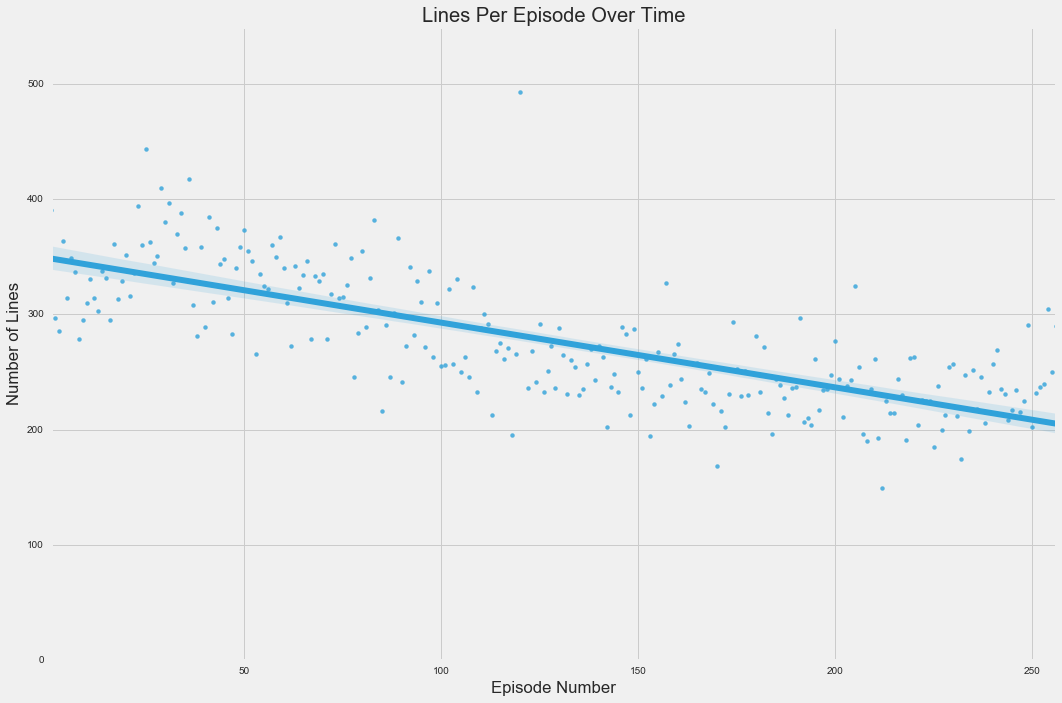

In [84]:
sns.regplot(x="episode_number", y="line", data=lines_by_episode,fit_reg=True)
plt.xlabel("Episode Number")
plt.xlim(min_episode_number,max_episode_number)
plt.ylim(0,550)
plt.ylabel("Number of Lines")
plt.title("Lines Per Episode Over Time")
plt.tight_layout()
plt.savefig("plots/Lines Per Episode.png")

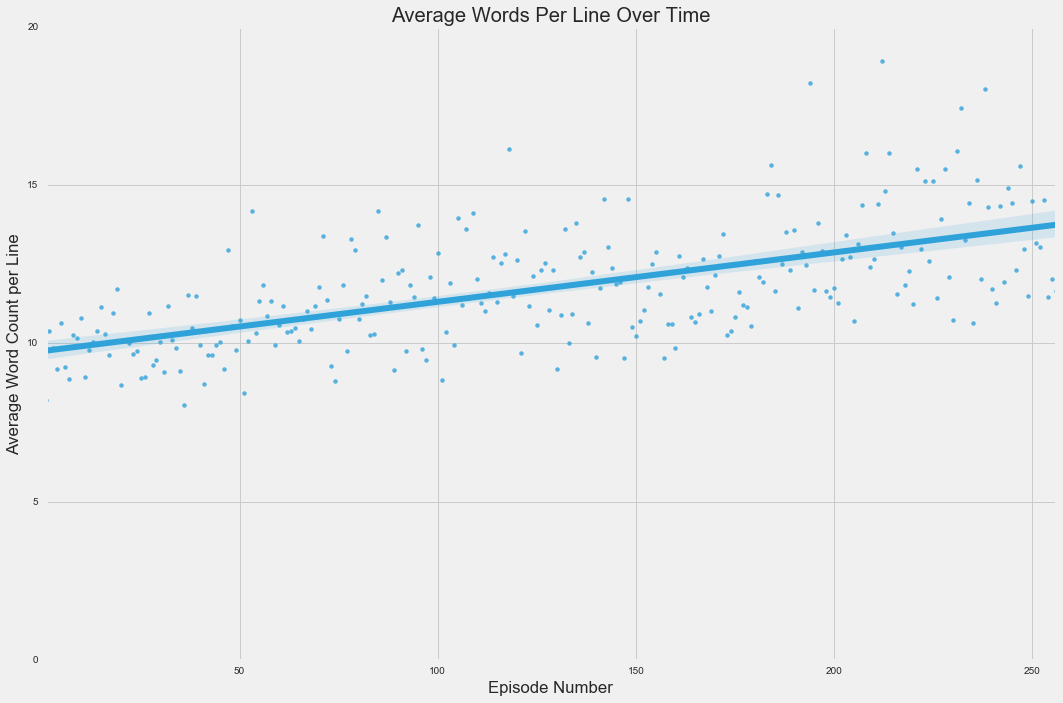

In [85]:
sns.regplot(x="episode_number", y="number_of_words", data=mean_words_per_line_by_episode)
plt.xlabel("Episode Number")
plt.xlim(min_episode_number,max_episode_number)
plt.ylim(0,20)
plt.ylabel("Average Word Count per Line")
plt.title("Average Words Per Line Over Time")
plt.tight_layout()
plt.savefig('plots/Mean Words per Line.png')

South Park has fewer lines per episodes, but more words per line as the show progresses. I wonder if this is typical of TV shows or unique to South Park. If anyone has data or domain experience please share! 

# The Rise and Fall of Jokes

In [86]:
# All of the times someone said "learned something".
sp['learned_something']= sp.line.str.contains('learned something',case=False)

# All of the times someone said "killed kenny".
sp['killed_kenny']= sp.line.str.contains('killed kenny',case=False)

# All of the times Linda or Stephen (Butters' parents) said "grounded".
sp['grounded']= (sp.line.str.contains('ground',case=False))&(sp.character.isin(["Stephen","Linda"]))

In [87]:
# The characters who say "killed kenny" the most.
sp.groupby('character').sum()['killed_kenny'].order(ascending=False).head(5)

character
Stan       43.0
Kyle       12.0
Cartman     3.0
Michael     1.0
Stuart      1.0
Name: killed_kenny, dtype: float64

In [88]:
# The characters who say "learned something" the most. 
sp.groupby('character').sum()['learned_something'].order(ascending=False).head(5)

character
Kyle           12.0
Stan           11.0
Cartman         4.0
New Cartman     1.0
Wendy           1.0
Name: learned_something, dtype: float64

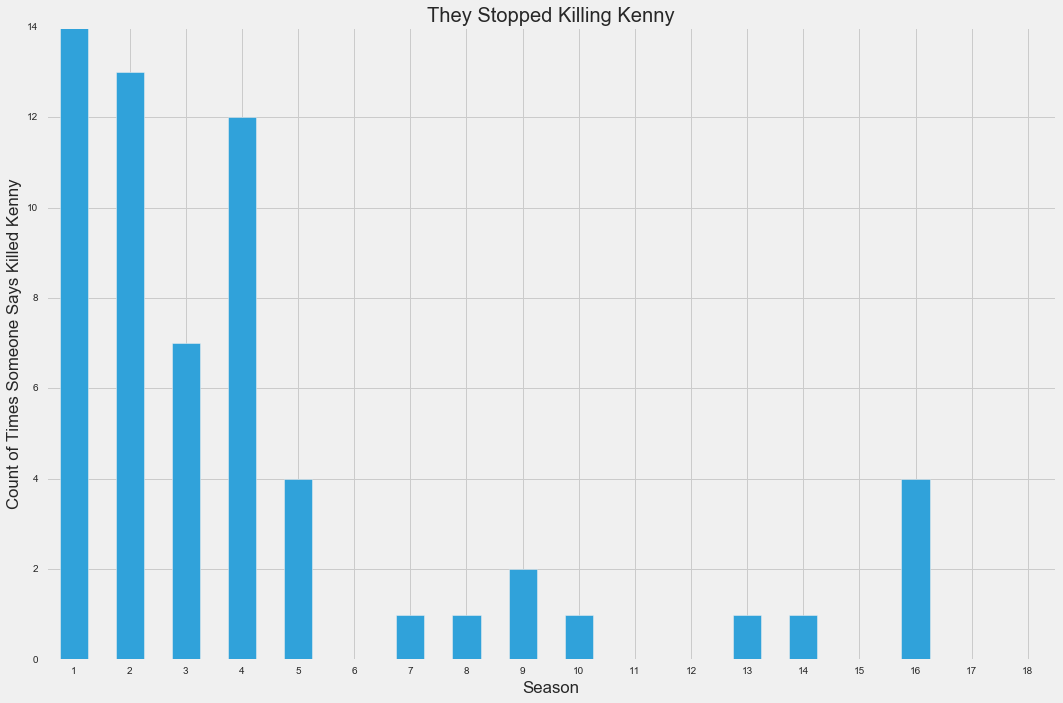

In [89]:
sp.groupby(['season'])['killed_kenny'].sum().plot(kind='bar')
plt.title("They Stopped Killing Kenny")
plt.ylabel("Count of Times Someone Says Killed Kenny")
plt.xlabel("Season")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('plots/Killed Kenny.png')

The amount of times someone says “Killed Kenny” has declined dramatically since the show’s early years. Actually, in later episodes, the writers will sometimes dance around these signature jokes. They tease the audience by putting Kenny in dangerous situations, but don’t kill him. 

Similarly, all characters have also stopped saying “learned something” as frequently. This was a recurring joke, often said by Kyle. However it has faded as the show has progressed:

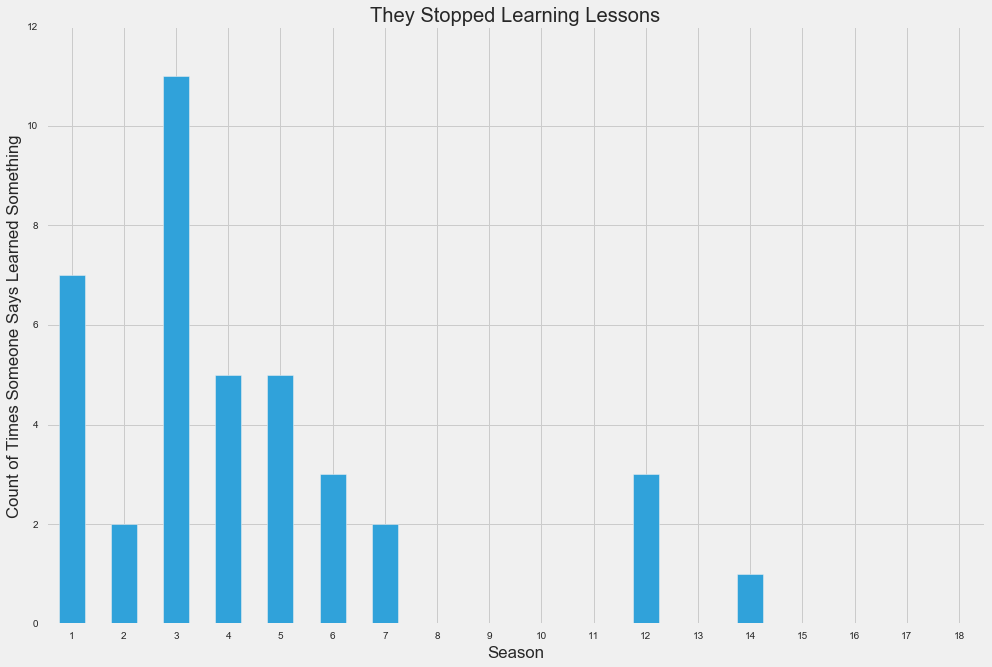

In [91]:
sp.groupby(['season'])['learned_something'].sum().plot(kind='bar')
plt.title("They Stopped Learning Lessons")
plt.ylabel("Count of Times Someone Says Learned Something")
plt.xlabel("Season")
plt.xticks(rotation=0)
# plt.tight_layout()
plt.savefig('plots/Learned Something.png')

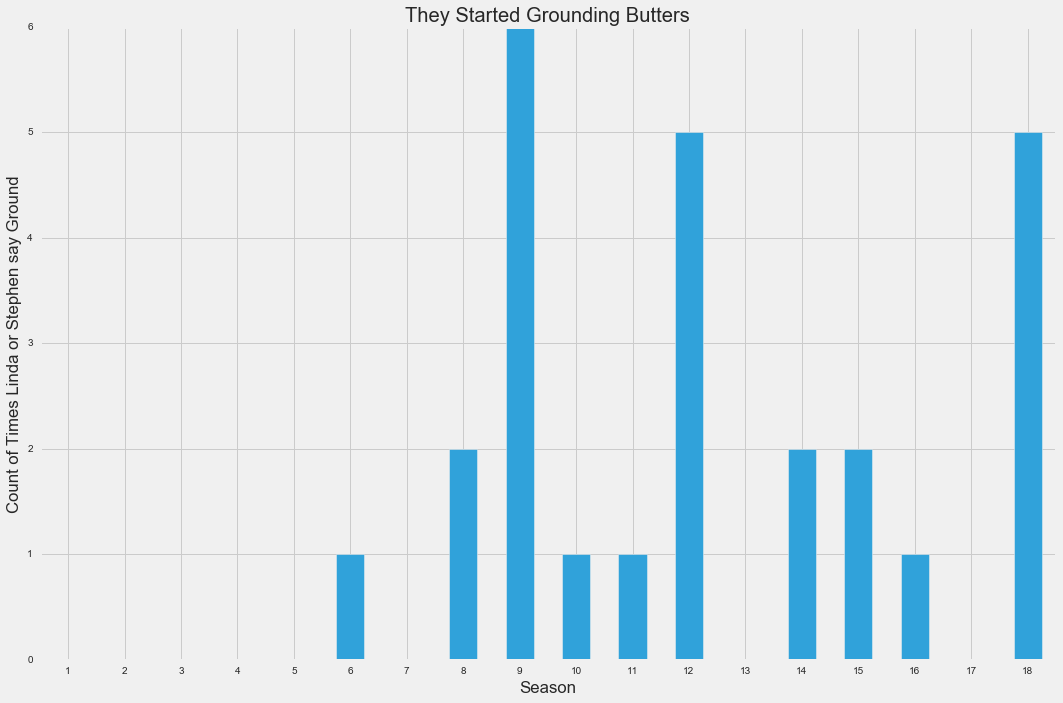

In [90]:
sp.groupby(['season'])['grounded'].sum().plot(kind='bar')
plt.title("They Started Grounding Butters")
plt.ylabel("Count of Times Linda or Stephen say Ground")
plt.xlabel("Season")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('plots/Grounded Butters.png')

What has replaced killing Kenny and Kyle learning lessons? One new joke is Butters getting grounded by his parents.

# Changes in the Structure of the Show

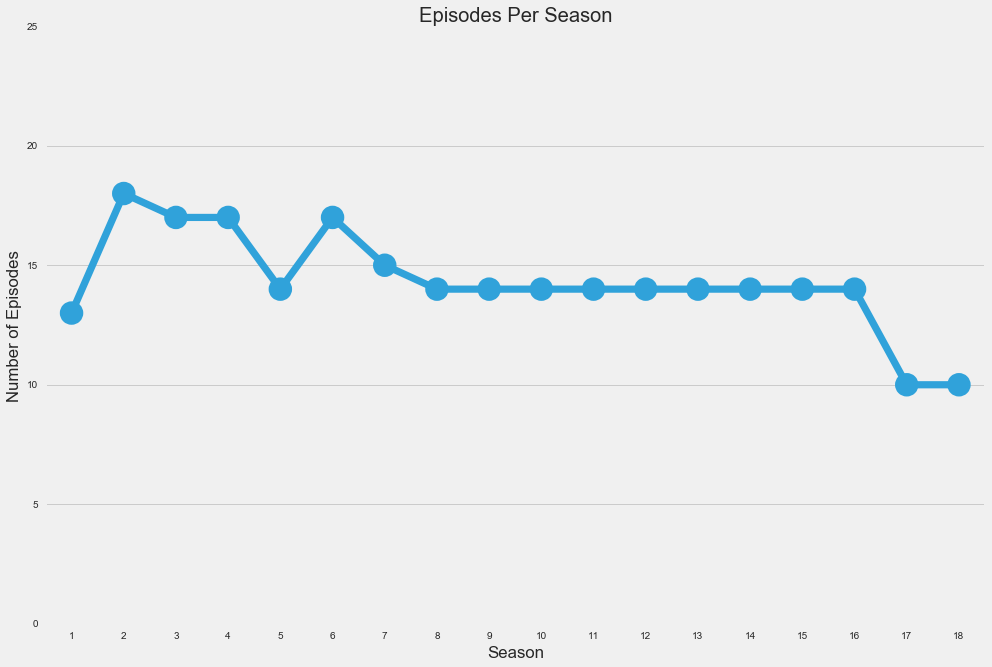

In [92]:
# Excluding the 19th season because to stay consistent with the transcript data.
imdb = imdb[imdb.season!=19]

# Using IMDB data because the transcript data is missing the last epsiode of the 18th season
episodes_per_season = imdb.groupby('season',as_index=False).count()[['episode',"season"]]

sns.pointplot(x="season", y="episode", data=episodes_per_season)
plt.ylim(0,25)
plt.ylabel('Number of Episodes')
plt.xlabel('Season')
plt.title('Episodes Per Season')
plt.savefig('plots/Episodes Per Season')


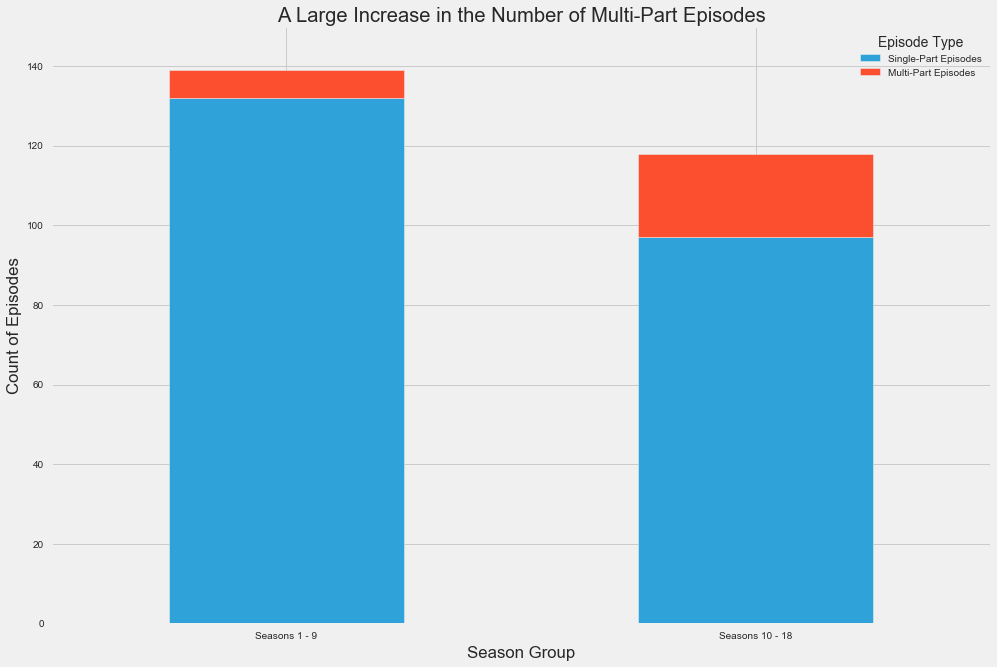

In [93]:
# Make a cleanly named column that divides the series by season.
imdb['Season Group'] = np.where(imdb.season>9,"Seasons 10 - 18", "Seasons 1 - 9")

# Make a cleanly named column that labels single-part vs multi-part episodes.
imdb['Episode Type'] = np.where(imdb.is_multi_part_episode, "Multi-Part Episodes","Single-Part Episodes")

episode_type_changes =  imdb.groupby(['Season Group','Episode Type'])[['is_multi_part_episode']].count().unstack(level=1)

# Drop unnecessary hierarchical column index.
episode_type_changes.columns = episode_type_changes.columns.droplevel()

# Rearrange the order for a cleaner visualization.
episode_type_changes = episode_type_changes[['Single-Part Episodes','Multi-Part Episodes']]

episode_type_changes.plot.bar(stacked=True)
plt.xticks(rotation=0)
plt.ylim(0,150)
plt.title('A Large Increase in the Number of Multi-Part Episodes')
plt.ylabel('Count of Episodes')
plt.savefig('plots/Change in Multi-Part Episodes.png')

In [131]:
# Calculate the number of times a character was the main character for an episode each season.
character_max_words = character_max_words.groupby(['character','season','episode_number']).count()[['rank_in_episode']].unstack(level=0)
character_max_words.columns = character_max_words.columns.droplevel()
character_max_words.reset_index(inplace=True)


In [132]:
character_max_words = character_max_words[['Cartman','Butters','Stan','Kyle','Randy','Jimmy','Chef','Mr. Garrison','Mrs. Garrison']]

In [138]:
# Split the show by the 128th episode (midway point of 256) and output to excel.
character_max_words.groupby(character_max_words.episode_number>128).count().to_excel('output_tables/Max Words After Episode 128.xlsx')

# Explore High Level Changes in Characters Roles

In [109]:
# Assign a value of -1 to all lines from seasons 1-9 and a value of 1 to a line from seasons 10 - 18.
sp['series_half'] = np.where((sp.season<= 9 ),-1,1)
sp.series_half.value_counts(normalize=True)

-1    0.609823
 1    0.390177
Name: series_half, dtype: float64

In [110]:
# There are not an even number of lines in each half. This normalizes to correct that.
sp['series_half_normalized'] = sp.series_half.map(lambda x: (2*x*.390177) if x==-1 else 2*(x*.609823))

In [111]:
sp[sp.character.isin(central_characters(sp,20))].groupby('character').mean(
)[['series_half_normalized']].sort_values('series_half_normalized',ascending=True).round(3)#.plot.box(vert=False)

,series_half_normalized
character,
Chef,-0.680
Mr. Garrison,-0.559
Jimbo,-0.550
Sheila,-0.374
Stan,-0.166
Gerald,-0.119
Kyle,-0.091
Kenny,-0.088
Liane,-0.078


The average score gives a sense of relative shift for each character. However, it can weigh a major shift by a minor character higher than a minor shift by a major character. 

In [112]:
sp[sp.character.isin(central_characters(sp,20))].groupby('character').sum(
)[['series_half_normalized']].sort_values('series_half_normalized').round().astype(int)#.to_excel('output_tables/Character Lines Across Series.xlsx')

,series_half_normalized
character,
Stan,-1270
Kyle,-648
Chef,-624
Mr. Garrison,-560
Jimbo,-306
Sheila,-212
Kenny,-77
Gerald,-75
Liane,-45


This weights change by absolute lines. Stan and Kyle had signifcant changes in total (normalized) lines even though 
they had very low relative changes.
That is simply because they speak a lot and so a small relative shift for them is still a large absolute change. 

# Deep Dive on Characters Roles

 This is a deep dive on the character that had a large shift in their lines as identified above.

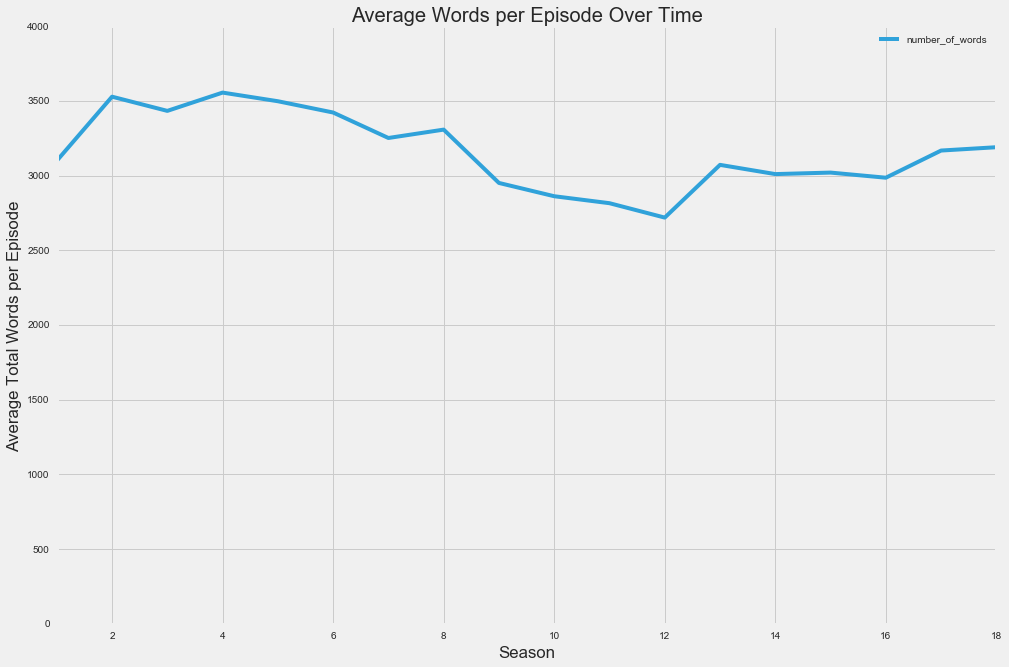

In [113]:
sp.groupby(['episode_number','season'],as_index=False).sum().groupby('season').mean()[['number_of_words']].plot()
plt.ylim(0,4000)
plt.title('Average Words per Episode Over Time')
plt.xlabel("Season")
plt.ylabel("Average Total Words per Episode")

The number of words has fluctuated throughout the show. Therefore, I will use relative percentages of episode dialogue 
instead of absolute word counts when comparing characters across episodes.

In [114]:
character_words_per_episode = sp.groupby(['episode_number','character','season','rating'],as_index=False)[['number_of_words']].sum()
character_words_per_episode.sort_values(['episode_number','number_of_words'],ascending=False,inplace=True)
character_words_per_episode[['rank_in_episode']]  = character_words_per_episode.groupby('episode_number').rank(method='min',ascending=False)[['number_of_words']]
character_words_per_episode['total_words_in_episode'] = character_words_per_episode.groupby('episode_number')['number_of_words'].transform(sum)
character_words_per_episode['percent_of_words_in_episode'] = (character_words_per_episode.number_of_words /  character_words_per_episode.total_words_in_episode).round(4)*100

In [127]:
# The number of times a character has had the most words in an episode.
character_max_words = character_words_per_episode[character_words_per_episode.rank_in_episode==1]

# Determine the top 12 characters who were the main character for an episode the most times.
character_max_words.groupby(['character']).count()[['rank_in_episode']].sort_values(
    'rank_in_episode',ascending=False).head(12)#.to_excel('output_tables/Most Words.xlsx')

,rank_in_episode
character,
Cartman,102
Stan,24
Randy,18
Kyle,16
Butters,8
Mr. Garrison,5
Jimmy,5
Chef,4
Narrator,4


These are the counts of how often a character leads an episode. This is determined by the character who has the most words in an episode. Clearly, Cartman carries the most episodes by a wide margin. 

In [117]:
character_words_per_episode = sp.groupby(['episode_number','character','season','rating'],as_index=False)[['number_of_words']].sum()
character_words_per_episode.sort_values(['episode_number','number_of_words'],ascending=False,inplace=True)
character_words_per_episode[['rank_in_episode']]  = character_words_per_episode.groupby('episode_number').rank(method='min',ascending=False)[['number_of_words']]
character_words_per_episode['total_words_in_episode'] = character_words_per_episode.groupby('episode_number')['number_of_words'].transform(sum)
character_words_per_episode['percent_of_words_in_episode'] = (character_words_per_episode.number_of_words /  character_words_per_episode.total_words_in_episode).round(4)*100

In [116]:
def plot_character_dialogue_by_ranking(character_words_per_episode,include_rankings=[],label=''):
    # This filters to only characters that achieved a designated speaking rank in each episode.
    included_characters_by_ranking = character_words_per_episode[character_words_per_episode.rank_in_episode.isin(include_rankings)]

    # Calculate the percentage of dialogue of the desingated character rankings each episode.
    dialogue_per_episode = included_characters_by_ranking.groupby(['episode_number','season'])['percent_of_words_in_episode'].sum()
    
    # Reset index level to convert from series to dataframe with season as a variable to group by.
    dialogue_per_episode = dialogue_per_episode.reset_index(level=1)
    
    dialogue_per_episode.rename(columns={'percent_of_words_in_episode':label},inplace=True)
    
    # Summarize each episode into a season,
    median_dialogue_per_season = dialogue_per_episode.groupby(['season']).median()[label]
    median_dialogue_per_season.plot(legend=True)
    return None

In [ ]:
plot_character_dialogue_by_ranking(character_words_per_episode,include_rankings=[1],label='')

plt.ylim(0,25)
plt.yticks(range(0,25))
plt.title('Characters Involved in Plot Over Time')
plt.ylabel('Median Number of Characters')
plt.xlabel('Season')

In [21]:
def plot_char_lines_by_season(sp,char_regex,plot_title,fig_name,line_plot=True):
    # Filters characters to those with a name that matches char_regex.
    character_lines_by_season = sp[sp.character.str.contains(char_regex,case=False)].groupby(['character','season']).sum()
    
    # Determine the percent of a season's dialogue each character had.
    character_lines_by_season = character_lines_by_season['number_of_words'].unstack(level=0).fillna(0)
    character_lines_by_season['words_in_season'] = sp.groupby('season')[['number_of_words']].sum()
    character_lines_by_season = character_lines_by_season.div(character_lines_by_season.words_in_season,axis=0).round(4) * 100
    character_lines_by_season.drop('words_in_season',axis=1,inplace=True)
    
    if line_plot:        
        # Take the 4 season rolling mean to smooth noise and show trend.
        character_lines_by_season.rolling(4,min_periods=1).mean().plot(kind='line')
    else:
        character_lines_by_season.rolling(4,min_periods=1).mean().plot(kind='bar')
    plt.title(plot_title)
    plt.xlabel('Season')
    plt.ylabel('Percentage of the Show\'s Words')
    plt.tight_layout()
    plt.savefig('plots/%s.png' %fig_name)
    return None


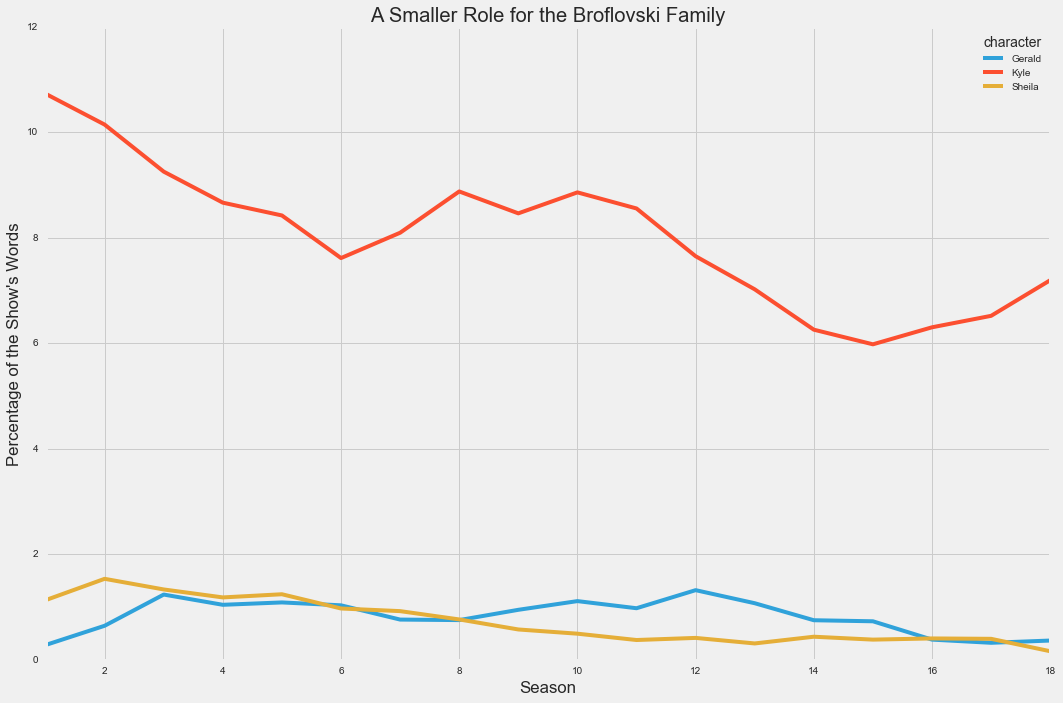

In [23]:
plot_char_lines_by_season(sp,
                          char_regex='^kyle$|^gerald$|^sheila$',
                          plot_title='A Smaller Role for the Broflovski Family',
                          fig_name='Broflovski')

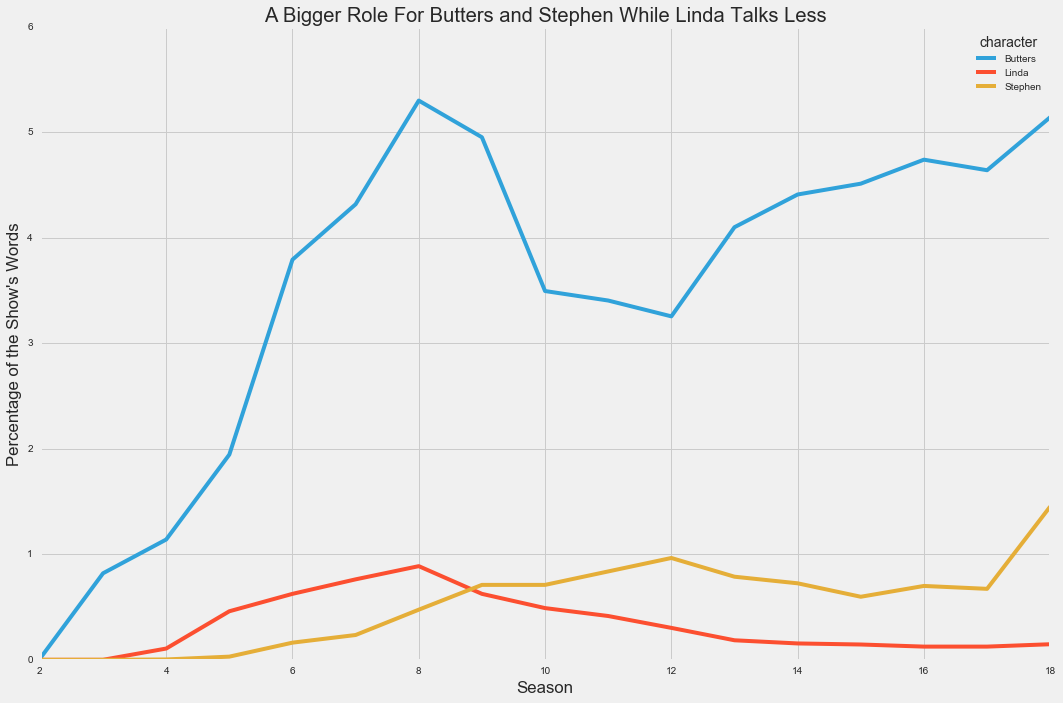

In [24]:
plot_char_lines_by_season(sp,
                          char_regex='^butters$|^stephen$|^linda$',
                          plot_title='A Bigger Role For Butters and Stephen While Linda Talks Less',
                          fig_name='Butters')

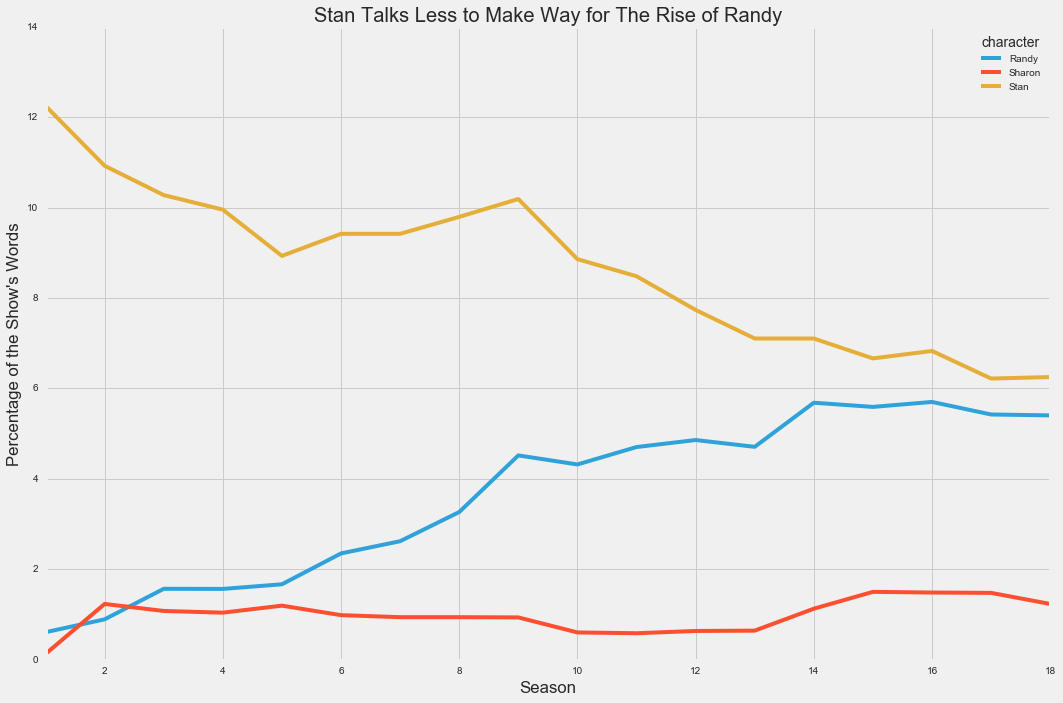

In [25]:
plot_char_lines_by_season(sp,
                          char_regex='^randy$|^stan$|^sharon$',
                          plot_title='Stan Talks Less to Make Way for The Rise of Randy',
                          fig_name='Marsh Family')

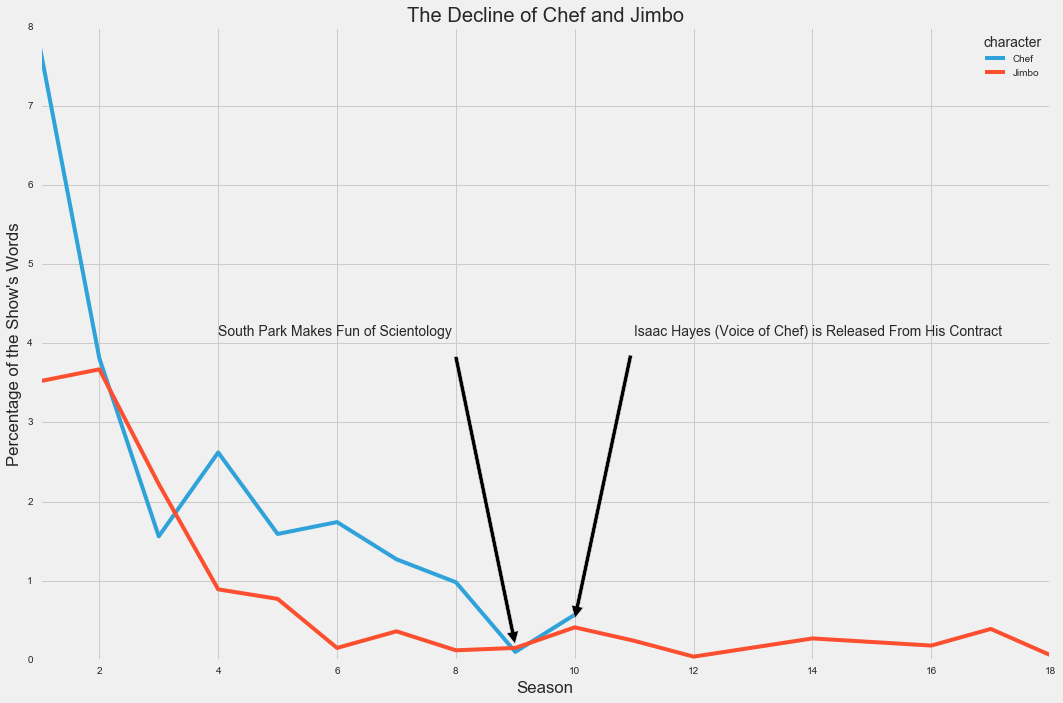

In [123]:
plot_char_lines_by_season(sp,
                          char_regex='^chef$|^jimbo$',
                          plot_title='The Decline of Chef and Jimbo',
                          fig_name='Chef Jimbo')
# Add annotations and resave.
plt.annotate('South Park Makes Fun of Scientology',xy=(9.05,0), xytext=(4, 4.1), arrowprops=dict(facecolor='black',shrink=0.05))
plt.annotate('Isaac Hayes (Voice of Chef) is Released From His Contract',xy=(9.95,.34), xytext=(11, 4.1), arrowprops=dict(facecolor='black',shrink=0.05))
plt.savefig('plots/Chef Jimbo.png')

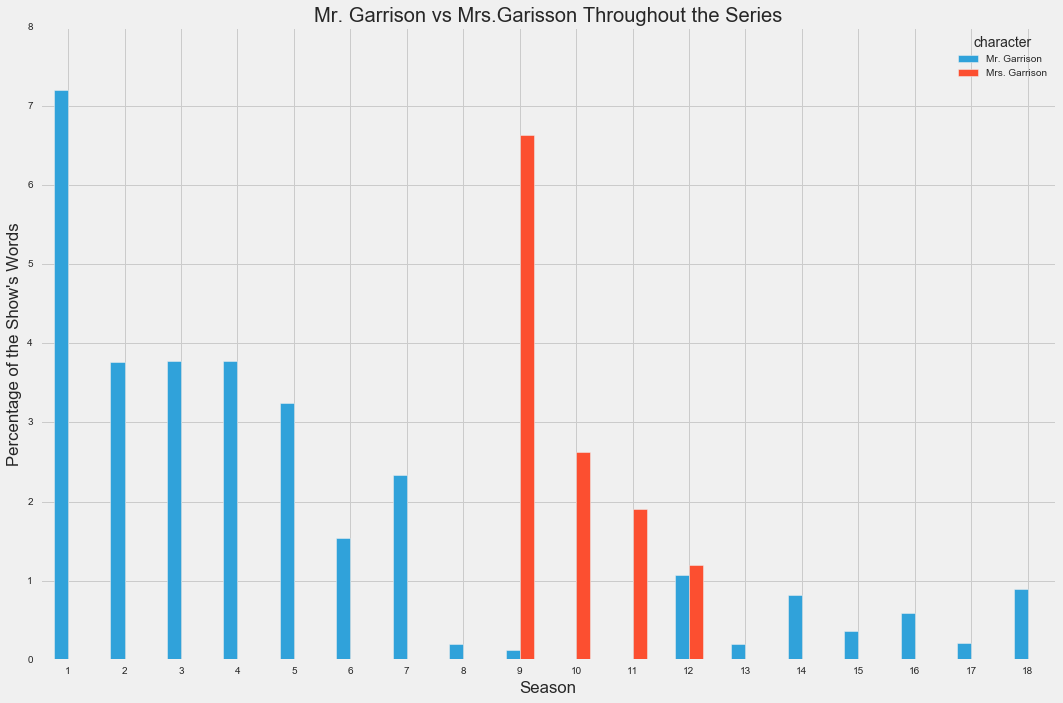

In [124]:
plot_char_lines_by_season(sp,
                          char_regex='(^mr(\.)? garrison)$|(mrs(\.)? garrison$)',
                          plot_title='Mr. Garrison vs Mrs.Garisson Throughout the Series',
                          fig_name='Garrison',
                          line_plot=False)

# IMDB Ratings

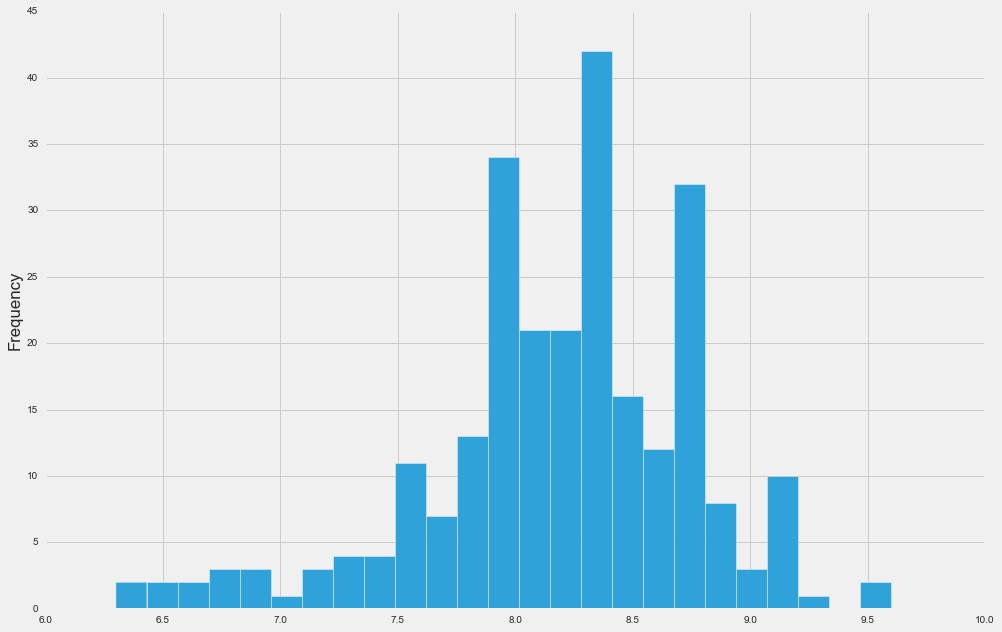

In [96]:
# The distribution of ratings.
imdb.rating.plot(kind='hist',bins=25)

This data came from an open opt-in internet poll, which introduces many biases. Take everything with a grain of salt.
It can show some possible trends, but it doesn't prove them. It is not representative of the entire south park watching public.

In [108]:
imdb.groupby(['Season Group','Episode Type'])[['rating']].mean().unstack(level=1).round(2)#.to_excel(
# 'output_tables/Multi-Part Ratings.xlsx')

rating                     
Episode Type    Multi-Part Episodes Single-Part Episodes
Season Group                                            
Seasons 1 - 9                  8.31                 8.31
Seasons 10 - 18                8.46                 7.96

The multi-part episodes have been substantially better rated than the single-part episodes since season 10 started. This trend towards more multi-part episodes is well received by audiences.

(5, 10)

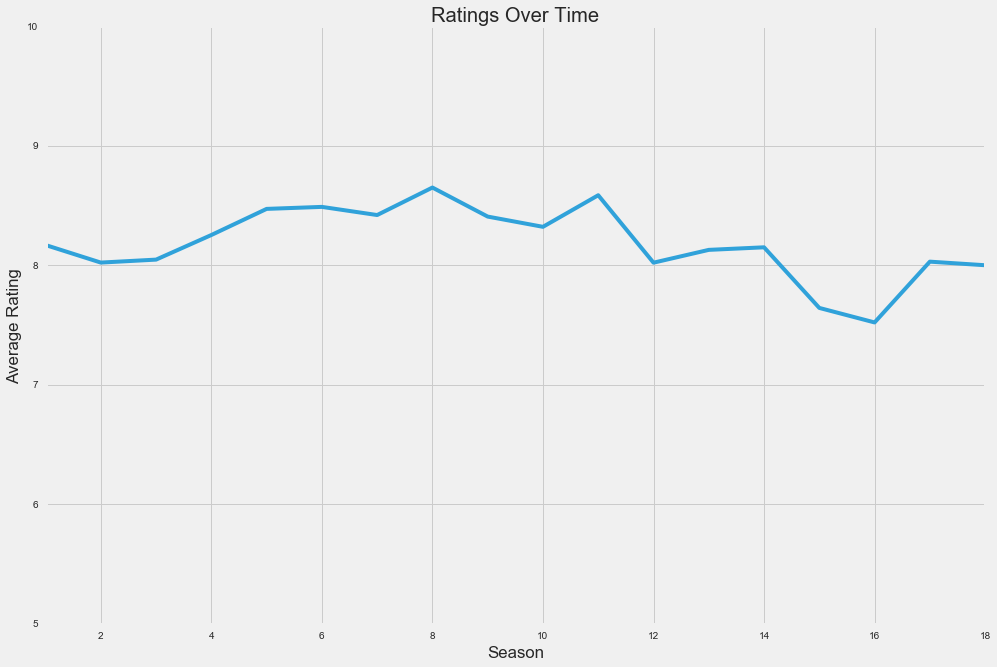

In [97]:
imdb.groupby('season').mean()['rating'].plot()
plt.title('Ratings Over Time')
plt.xlabel('Season')
plt.ylabel('Average Rating')
plt.ylim(5,10)

In [107]:
# Calculates the average rating based on the main character of the episode
character_words_per_episode[(character_words_per_episode.character.isin(
            ['Cartman','Butters','Stan','Kyle','Randy','Mr. Garrison','Mrs. Garrison','Jimmy','Chef']))&
            (character_words_per_episode.rank_in_episode==1)].groupby(
            ['character']).mean()[['rating']].round(2).sort_values('rating',ascending=False)#.to_excel(
# 'output_tables/IMDB Character Ratings.xlsx')

,rating
character,
Cartman,8.32
Butters,8.31
Mr. Garrison,8.26
Randy,8.18
Stan,8.18
Mrs. Garrison,8.17
Kyle,8.04
Chef,7.93
Jimmy,7.84


Clearly, fans love Cartman. Butters is almost tied with Cartman and Randy is tied with Stan. This is impressive considering that Butters and Randy started as background characters. They now lead episodes and get comparable ratings to the shows’ most important characters. Even so, Cartman is the show’s all star. He carries the most episodes and has the highest ratings. Kyle is the least popular of the boys. In fact, Matt and Trey almost killed him off in the fifth season. Instead they just shrunk his role. That seems to fit audience preferences.

# South Park and Politics

In [99]:
sp['president']= sp.line.str.contains('president',case=False)
sp['politics']= sp.line.str.contains('clinton|george bush|obama|mccain|palin|al gore|vote|romney|kerry',case=False)

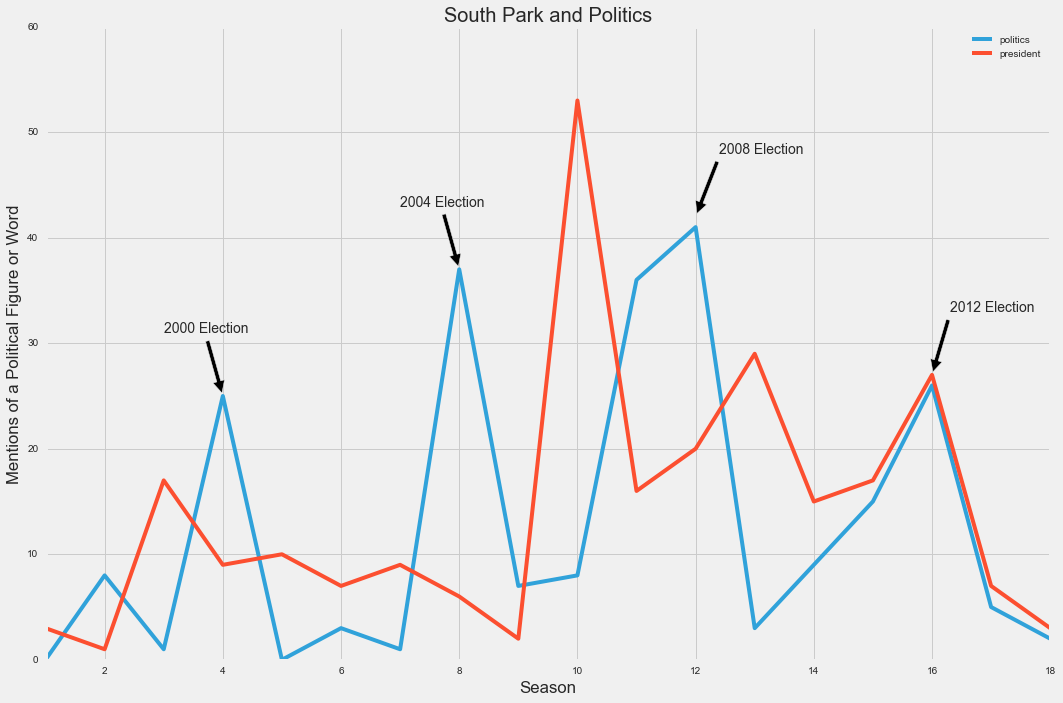

In [100]:
sp.groupby('season')[['politics','president']].sum().plot()
plt.annotate('2000 Election',xy=(4,25), xytext=(3, 31), arrowprops=dict(facecolor='black',shrink=0.05))
plt.annotate('2004 Election',xy=(8,37), xytext=(7, 43), arrowprops=dict(facecolor='black',shrink=0.05))
plt.annotate('2008 Election',xy=(12,42), xytext=(12.4, 48), arrowprops=dict(facecolor='black',shrink=0.05))
plt.annotate('2012 Election',xy=(16,27), xytext=(16.3, 33), arrowprops=dict(facecolor='black',shrink=0.05))
plt.xlabel('Season')
plt.ylabel('Mentions of a Political Figure or Word')
plt.title('South Park and Politics')
plt.tight_layout()
plt.savefig('plots/South Park and Politics.png')

As fans might suspect, South Park often gets involved in politics. The show makes more political references 
during election years with the blue line. The red line is the number of times a character says “president”. 
In between election years, there is a rise in jokes about the incumbent. Making fun of politics and politicians 
will always be a South Park signature.

# How Dialogue Has Shifted Among Character Roles

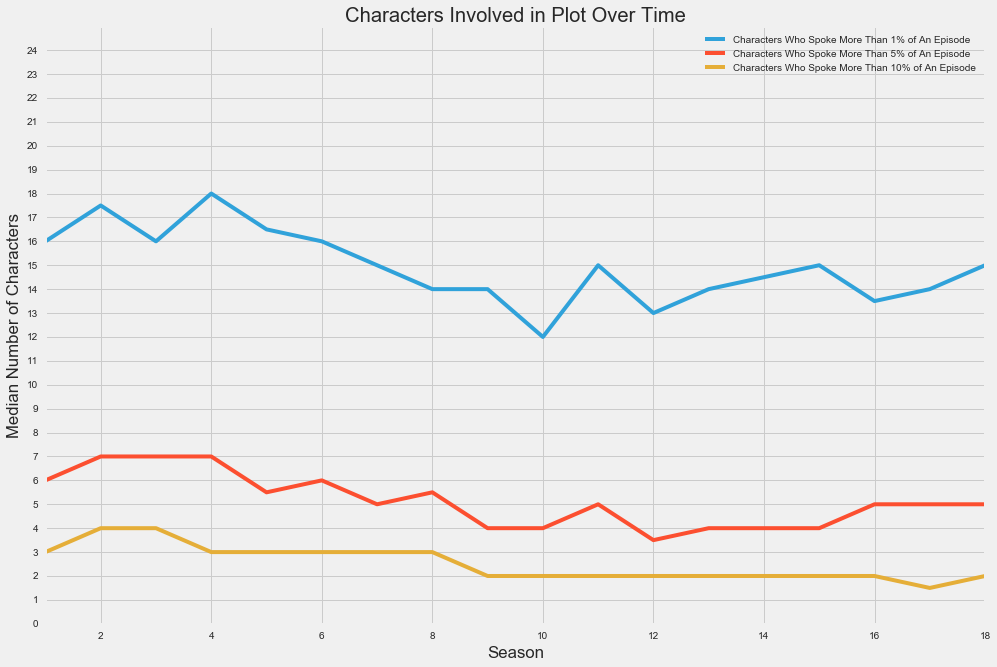

In [101]:
character_percent_words_of_episode = sp.groupby(['episode_number','season','character']).sum()['number_of_words'].reset_index()
character_percent_words_of_episode['words_in_episode'] = sp.groupby('episode_number')[['number_of_words']].transform('sum')
character_percent_words_of_episode['percent_of_words'] = (character_percent_words_of_episode.number_of_words/ character_percent_words_of_episode.words_in_episode).round(4)*100
character_percent_words_of_episode.reset_index(inplace=True)
def plot_character_count_above_threshold(character_percent_words_of_episode,percentage_threshold):
    # Determine the legend label name.
    legend_name = 'Characters Who Spoke More Than %s%% of An Episode'% percentage_threshold
    
    # Filter based on the threshold.
    character_percent_words_of_episode = character_percent_words_of_episode[character_percent_words_of_episode.percent_of_words>percentage_threshold]
    
    # Aggregate the count of characters above the threshold for each episode.
    character_count_per_episode = character_percent_words_of_episode.groupby(['episode_number','season'],as_index=False).count()
    
    # Change the name of the column to be plotted to the desired legend name
    character_count_per_episode.rename(columns={'number_of_words':legend_name},inplace=True)
    
    # Calculate the median count of character for each season & plot.
    median_character_count_per_season = character_count_per_episode.groupby('season')[legend_name].median()                                       
    median_character_count_per_season.plot(legend=True)
    return None

plot_character_count_above_threshold(character_percent_words_of_episode,percentage_threshold=1)
plot_character_count_above_threshold(character_percent_words_of_episode,percentage_threshold=5)
plot_character_count_above_threshold(character_percent_words_of_episode,percentage_threshold=10)

plt.ylim(0,25)
plt.yticks(range(0,25))
plt.title('Characters Involved in Plot Over Time')
plt.ylabel('Median Number of Characters')
plt.xlabel('Season')

The spread of the dialogue has changed as well. The lead character’s median dialogue each season started at 20% (the blue line). That has increased to 25%, which is a 25% increase from 20%. Who is speaking less?

It’s not the number 2 most talkative character of the show (the red line). That has held fairly steady at 15%. However, all of the other character besides the the two most talkative are speaking less (the yellow line):

# The Boys vs Major Characters vs Other Characters

In [82]:
# Copy of south park dataframe where characters are  into buckets 
sp_main_characters = sp.copy()

# Bucket the 4 boys together
sp_main_characters.character = sp_main_characters.character.str.replace('Stan|Cartman|Kenny|Kyle','The Boys',case=False)

n_supporting_characters = 21
central_characters_lst = central_characters(sp_main_characters,n_supporting_characters+1)
try:
    central_characters_lst.remove('Announcer')
    n_supporting_characters = n_supporting_characters - 1
except ValueError:
    pass

sp_main_characters.ix[sp_main_characters.character.isin(central_characters_lst[1:]),
                     ['character']] = "Top %s Supporting Characters" % n_supporting_characters

# Bucket all remaining characters together as "Other Character"
sp_main_characters.ix[~((sp_main_characters.character.isin(central_characters_lst[:1]))|
                      (sp_main_characters.character=="Top %s Supporting Characters" % n_supporting_characters)),
                     ['character']] = "Other Characters"

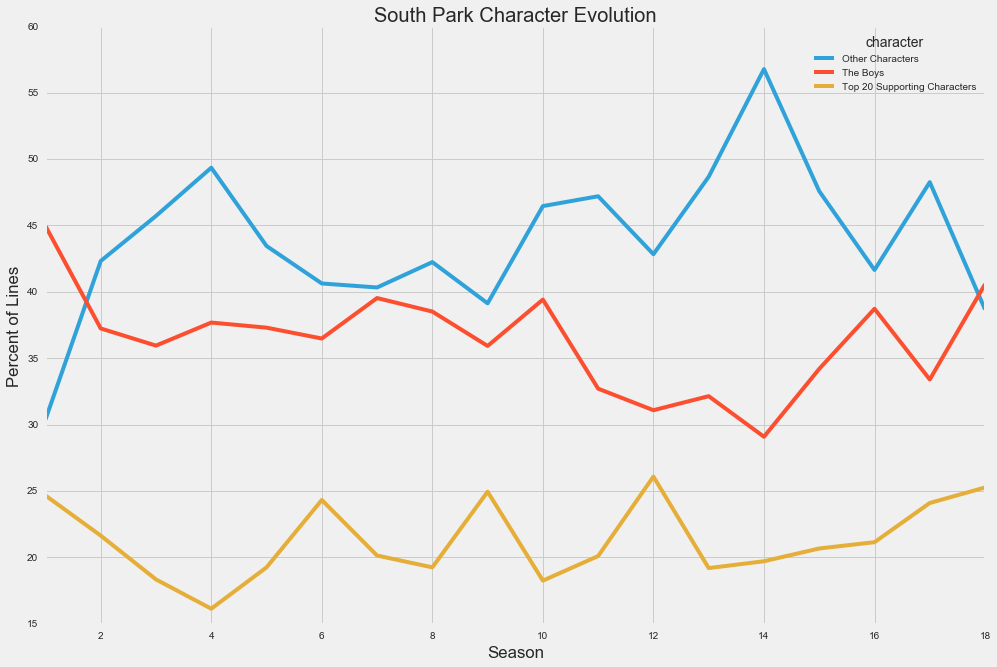

In [83]:
# Calculate the % of lines per epsiode for each character group
lines_per_epsiode = sp_main_characters.groupby(['episode_number','season','character']).count()[['line']].unstack(level=2)
lines_per_epsiode.columns = lines_per_epsiode.columns.droplevel()
lines_per_epsiode = lines_per_epsiode.div(lines_per_epsiode.sum(axis=1), axis=0).round(4)*100
lines_per_epsiode.reset_index().drop('episode_number',axis=1).groupby(['season']).mean().fillna(0).rolling(1).mean().plot()
plt.title('South Park Character Evolution')
plt.xlabel('Season')
plt.ylabel('Percent of Lines')

This didn't make it to the main post because there weren't obvious patterns. The boy's importance varies. Sometimes the show is more or less about them.